# Learning and Decision Making

## Laboratory 4: Partially observable Markov decision problems

In the end of the lab, you should submit all code/answers written in the tasks marked as "Activity n. XXX", together with the corresponding outputs and any replies to specific questions posed to the e-mail <adi.tecnico@gmail.com>. Make sure that the subject is of the form [&lt;group n.&gt;] LAB &lt;lab n.&gt;.

### 1. Modeling

Consider once again the guessing game domain described in the Homework and which you described as a POMDP.

Recall that:

* The opponent can hold one of two cards in hand: an Ace of Clubs (A&clubs;) and an Ace of Diamonds (A&diams;). The agent must guess which card the opponent is holding. 

* For every right answer, the agent wins 1EUR, and every wrong answer costs the agent 1EUR. 

* The agent can also try to _peek_. 

* When the agent peeks, it sees the right card with a probability of 0.9 and the wrong card with probability 0.1.

* The game restarts whenever the agent makes a guess.

Consider throughout that $\gamma=0.9$.

---

#### Activity 1.        

Implement your POMDP in Python. In particular,

* Create a list with all the states;
* Create a list with all the actions;
* Create a list with all the observations
* For each action, define a `numpy` array with the corresponding transition probabilities;
* For each action, define a `numpy` array with the corresponding observation probabilities;
* Define a `numpy`array with the cost that you defined in your homework.

The order for the states and actions used in the transition probability and cost matrices should match that in the lists of states and actions. 

**Note**: Don't forget to import `numpy`.

---

In [62]:
import numpy as np
from pandas import *

X = ['AC', 'AD'] # 'AC' = ace of clubs, 'AD' = ace of diamonds

A = ['GC', 'GD', 'PEEK'] # Guess Clubs, Guess Diamonds, Peek

Z = ['OC','OD','NOTHING'] # Observe Clubs, Observe Diamonds, Nothing
     

P_GC = np.array([[0.5, 0.5],
                 [0.5, 0.5]])
     
P_GD = np.array([[0.5, 0.5],
                 [0.5, 0.5]])

P_PEEK = np.array([[1, 0],
                   [0, 1]])
     
O_GC = np.array([[0, 0, 1],
                 [0, 0, 1]])

O_GD = np.array([[0, 0, 1],
                 [0, 0, 1]])
     
O_PEEK = np.array([[0.9, 0.1, 0],
                   [0.1, 0.9, 0]])


C = np.array([[0,1,0.1],
              [1,0,0.1]])


# This dictionary will represent the POMDP in our code.
# kEY description: "X" = space of states, 
#                  "A" = possible actions,
#                  "Z" = possible observations,
#                  "Pa's" = transition matrix for actions in A (MDP["A"] and MDP["Pa's"] must respect the same order)
#                  "Oa's" = observation matrix for actions in A (MDP["A"] and MDP["Oa's"] must respect the same order) 
#                  "C" = cost function for the MDP

pomdp = {"X": X, "A": A, "Z": Z, "Pa's": [P_GC, P_GD, P_PEEK], "Oa's": [O_GC, O_GD, O_PEEK], "C":C}

### 2. Sampling

You are now going to sample random trajectories of your POMDP and observe the impact it has on the corresponding belief.

---

#### Activity 2.

Generate a random POMDP trajectory using a uniformly random policy. In particular, from a random initial state $x_0$ generate:

1. A sequence of 10,000 states by selecting the actions uniformly at random;
2. The corresponding sequence of 10,000 actions;
3. The corresponding sequence of 10,000 observations.

---

In [82]:
import warnings
warnings.filterwarnings("ignore")

def generateRandomTrajectory(POMDP, policy, s0, steps=100):  #only 100 for debugging
    states = np.array([s0])
    actions = np.array([])
    observations = np.array([])
    
    for i in range(0, steps):
        random_action = np.random.choice(len(POMDP['A']), size=1, p=policy[states[i]])
        possible_state = np.random.choice(len(POMDP['X']), size=1, p=POMDP["Pa's"][random_action][states[i]])
        possible_observation = np.random.choice(len(POMDP['Z']), size=1, p=POMDP["Oa's"][random_action][states[i]])
        
        states = np.append(states, possible_state)
        actions = np.append(actions, random_action)
        observations = np.append(observations, possible_observation)

    return [states, actions, observations]

initial_state = 0

random_policy =np.array([[1/3, 1/3, 1/3],
                         [1/3, 1/3, 1/3]]);

[states, actions, observations] = generateRandomTrajectory(pomdp, random_policy, initial_state, 10000)


---

#### Activity 3.

For the POMDP trajectory generated in Activity 2, compute the corresponding sequence of beliefs, assuming that the initial belief is $\mathbf{b}_0=[0.5, 0.5]$. Report the resulting beliefs, ignoring duplicate beliefs or beliefs whose distance is smaller than $10^{-4}$.

**Note 1:** You may want to define a function `belief_update` that receives a belief, an action and an observation and returns the updated belief.

**Note 2:** To compute the distance between vectors, you may find useful `numpy`'s function `linalg.norm`.


---

In [83]:

def beliefUpdate(POMDP, belief, action, observation):
    a1_hat = np.dot(belief, POMDP["Pa's"][int(action)])
    diag = np.diagflat(POMDP["Oa's"][int(action)][:,int(observation)])
    a1 = np.dot(a1_hat, diag)
    norm_a1 = a1 / np.sum(a1)
    return norm_a1


def existsInList(elem, lista):  #only works for 2d arrays
    for i in range(0,len(lista)):	
        dist = np.linalg.norm(lista[i]-elem)
        if (lista[i][0] == elem[0]) and (lista[i][1] == elem[1]) or dist < 1e-5:
            return True
    return False


def computeBeliefSequence(POMDP, initial_belief, actions, observations):
    input_belief = initial_belief
    beliefs = np.array([initial_belief])

    for i in range(0,len(actions)):

        new_belief = beliefUpdate(pomdp, input_belief, actions[i],observations[i])

        if not existsInList(new_belief, beliefs):
            beliefs = np.append(beliefs, [new_belief],axis=0)
        input_belief = new_belief
    
    return beliefs

beliefs = computeBeliefSequence(pomdp,np.array([0.5,0.5]), actions, observations)


### 3. Solution methods

In this section you are going to compare different non-exact solution methods.

---

#### Activity 4

Compute the solution for the underlying MDP and report the corresponding optimal policy and optimal cost-to-go. 

** Note:** You may reuse code from previous labs.

---

In [54]:

# underlying MDP
mdp = {"X": pomdp['X'], "A": pomdp['A'], "Pa's": pomdp["Pa's"], "C": pomdp['C']} 

#@brief: 
#      This function computes the policy iteration algorithm to find the optimal policy (π*).
#
#@param: - MDP dictionary
#        
#@return: 
#        returns a tuple that contains the optimal policy (π*) and the number of iterations required to compute it.
def policyIteration(MDP, gamma):
    pi = np.ones((len(MDP['X']), len(MDP['A']))) /2
    quit = False
    i = 0
    
    while not quit:
        
        #initialize cπ and pπ with first line of pi multiplyed by the costs for the first action
        cpi = np.diag(pi[:,0]).dot(MDP["C"][:,[0]])
        ppi = np.diag(pi[:, 0]).dot(MDP["Pa's"][0])
        
        # loop over the rest of the actions 
        for a in range(1, len(MDP["A"])):
            cpi += np.diag(pi[:,a]).dot(MDP["C"][:,[a]])
            ppi += np.diag(pi[:, a]).dot(MDP["Pa's"][a])

        J = np.linalg.inv(np.eye(len(MDP["X"])) - gamma * ppi).dot(cpi)
        
        Qa = [None] * len(MDP["A"])
        
        # loop over every action
        for a in range(0, len(MDP["A"])):
            Qa[a] = MDP["C"][:,[a]] + gamma * MDP["Pa's"][a].dot(J)
        
        pinew = np.zeros((len(MDP['X']), len(MDP['A'])))
        
        # loop over every action
        for a in range(0, len(MDP["A"])):
            pinew[:, a, None] = np.isclose(Qa[a], np.min(Qa, axis=0), atol=1e-8, rtol=1e-8).astype(int)

        pinew = pinew / np.sum(pinew, axis=1, keepdims=True)
        quit = (pi == pinew).all()
        pi = pinew
        i +=1
    return (pi, i)

#@brief: 
#      This function computes the valueIteration algorithm to find the optimal cost to go J*.
#
#@param: - MDP (as explained in activity 1)
#        - tolerance, which is used to stop the algorithm when Jnew and J are close by a small factor
#        - gamma, which represents the inflation.
#
#@return: 
#        returns a tuple that contains J* and the number of iterations required to compute J*
def valueIteration(MDP, tolerance, gamma):
    
    #@brief:
    #      computes Jnew.
    #
    #@param: - Qa, is a vector with the Q for every action.
    #
    #@return: 
    #       returns a column vector with the minimun value in every line of Qa.
    def computeJnew(Qa):
        Jnew = np.zeros((len(Qa[0]),1))
        for i in range(0, len(Qa[0])):
            min = Qa[0][i]
            for j in range(1, len(Qa)):
                if Qa[j][i] < min:
                    min = Qa[j][i]
            Jnew[i][0] = min
        return Jnew
    
    J = np.zeros((len(MDP["X"]), 1)) # initialize J
    err = 1
    i=0
    while err > tolerance:
        
        Qa = [None]*len(MDP["A"]) #initialize empty list for Q values for actions a in A
        
        # loop over actions and compute Qa
        for a in range(0, len(MDP["A"])):
            Qa[a] = MDP["C"][:,[a]] + gamma * MDP["Pa's"][a].dot(J)
        
        Jnew = computeJnew(Qa)
        err = np.linalg.norm(Jnew - J)
        i += 1
        J = Jnew    
    return (J, i)

optimal_policy, iterations = policyIteration(MDP=mdp, gamma=0.9)
J_optimal, iterations = valueIteration(MDP=mdp, tolerance=1e-8, gamma=0.9)


---

#### Activity 5

For each of the beliefs computed in Activity 3, compute the action prescribed by:

* The MLS heuristic;
* The AV heuristic;
* The Q-MDP heuristic.

---

In [56]:
import sys

################################### Functions From Lab 3 ########################################################
#@brief:
#   Computes the costs for that policy (Cπ).
#
#@param: - costs, matrix that represents the costs for every state
#        - policy, represents the policy we want to know the costs.
#
#@return: 
#        returns the costs for the policy (Cπ).
def calculate_Cpi(costs, policy):
    cpi = np.zeros(len(policy))
   
    # loop over states
    for i in range(0, len(policy)):        
        # loop over actions to compute sum(pi(a|x) * c(a,x))

        sum = 0
        for j in range(0, len(costs[0])):
            sum += policy[i][j]*costs[i][j]

        cpi[i] = sum
    return cpi

#@brief:
#   Computes the transiction matrix for a specific policy (Pπ).
#
#@param: - MDP (as explained in activity 1).
#        - policy, that represents the policy we want to know the transiction matrix.
#
#@return: 
#        returns the transiction matrix for the policy (Pπ).
def transition_Probabilities_For_Policy(MDP, policy):
    Ppi = np.zeros((len(MDP["X"]),len(MDP["X"]))) # creates a matrix NxN where N is the size of X
    
    for i in range(0, len(MDP["X"])):
        for j in range(0, len(MDP["X"])):
            
            # for every entry we need to loop over possible actions to compute ∑ π(a|x)*P(y|x,a)
            sum = 0
            for k in range(0,len(MDP["A"])):
                sum += policy[i][k] * MDP["Pa's"][k][i][j]
            
            Ppi[i][j] = sum
    return Ppi

########################################## Heuristics ##########################################################

#@brief:
#      computes the next action acording to a policy and a belief using the MLS Heuristic studied in 
#      theoretical lessons.
#
#@param: - belief, vector with the beliefs for every state.
#        - policy, matrix that represents the policy we want to follow.
#@return: 
#       returns an integer wich is the index of the action in POMDP dictionary.
def mlsHeuristic(belief,policy):
    index = np.argmax(belief)
    action = np.argmax(policy[index])
    return action


#@brief:
#      computes the next action acording to a policy and a belief using the AV Heuristic studied in 
#      theoretical lessons.
#
#@param: - belief, vector with the beliefs for every state.
#        - policy, matrix that represents the policy we want to follow.
#@return: 
#       returns an integer wich is the index of the action in POMDP dictionary.
def avHeuristic(belief, policy):
    
    max = -1
    max_action = None
    for j in range(0, len(policy[0])): # loop over actions
        sum = 0
        for i in range(0, len(policy)): # loop over states
            sum += policy[i][j]*belief[i] # b(x)*I(a = π mdp(x))
            
        if (sum > max):
            max = sum
            max_action = j # stores the action.
            
    return max_action

# test: avHeuristic([0.2, 0.2, 0.6], np.array([[0.2, 0.8, 0], [0, 1, 0], [0.5, 0, 0.5]]))

#@brief:
#      computes the next action acording to a policy and a belief using the QMDP Heuristic studied in 
#      theoretical lessons.
#
#@param: - belief, vector with the beliefs for every state.
#        - policy, matrix that represents the policy we want to follow.
#        - POMDP, dictionary with the structure that reprensents the POMDP. This is required for calculating Q's.
#@return: 
#       returns an integer wich is the index of the action in POMDP dictionary.
def QMDPHeuristic(belief, policy, POMDP):
    gamma = 0.9
    Cpi = calculate_Cpi(POMDP["C"], policy)
    Ppi = transition_Probabilities_For_Policy(POMDP, policy)
    Jpi = np.dot(np.linalg.inv((np.identity(2)-(gamma*Ppi))), Cpi)

    Qa = [None]*len(POMDP["A"]) #initialize empty list for Q values for actions a in A
    print (Qa)
    
    # loop over actions and compute Qa
    for a in range(0, len(POMDP["A"])):
        Qa[a] = POMDP["C"][:,a] + gamma * POMDP["Pa's"][a].dot(Jpi)
            
    # loop over action and for every action a calculate the inner product between Qa and the belief in order
    # to find the action that minimizes Qa.belief.
    min = sys.maxsize
    action = None
    for a in range(0, len(POMDP["A"])):
        if np.dot(belief, Qa[a]) < min:
            action = a
            min = np.dot(belief, Qa[a])
            
    return action

QMDPHeuristic(np.array([0.7, 0.3]), optimal_policy, pomdp)
        

[None, None, None]


2

---

#### Activity 6

Suppose that the optimal cost-to-go function for the POMDP can be represented using the $\alpha$-vectors

$$
\left\{
\begin{bmatrix}
2.795\\
3.795
\end{bmatrix},
\begin{bmatrix}
3.795\\
2.795
\end{bmatrix},
\begin{bmatrix}
3.105\\
3.105
\end{bmatrix}\right\}$$

corresponding to the actions 'Guess clubs', 'Guess diamonds' and 'Peek', respectively. Represent the optimal cost-to-go function and compare the optimal policy with the MDP heuristics from Activity 5 in the beliefs computed in Activity 3.

** Note: ** Don't forget to import `matplotlib`, and use the magic `%matplotlib notebook`.

---

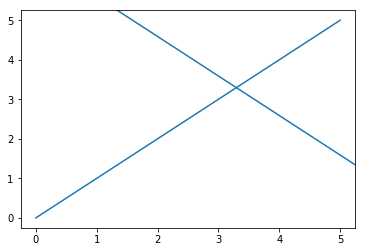

In [91]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

x = np.linspace(0,5)
y = x

def newline(p1, p2):
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax])
    ax.add_line(l)
    return l

p1 = [2.795, 3.795]
p2 = [3.795, 2.795]
plt.plot(x, y)
newline(p1,p2)
plt.show()